In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np
#from jax import numpy as jnp

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 1000
SEED = 0

In [ ]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            #labels.append([t, 1-t])
            #labels.append([np.sin(np.pi/4*t), np.cos(np.pi/4*t)])
            #labels.append([[1, 0],[t,1-t]])
            x=[t,1-t,0,0,0,0,0,0]
            xr=np.array(x).reshape([2,2,2])
            labels.append(xr)
            #labels.append([[t, 0., 0],[1-t,0.,0]])
            #labels.append([[t, 0.],[1-t,0.]])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences

train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [4]:
x = np.arange(8).reshape((2,2,2))

In [5]:
x

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [6]:
y= x.reshape((8))

In [7]:
y

array([0, 1, 2, 3, 4, 5, 6, 7])

In [8]:
x[0,0,0]

0

In [9]:
x[0,0,1]

1

In [51]:
x[0,1,0]

2

In [64]:
train_labels[10,1,0,0]

1

In [8]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [9]:
from lambeq import Reader, cups_reader, spiders_reader, stairs_reader

raw_train_diagrams=[]
raw_dev_diagrams=[]
raw_test_diagrams=[]

#raw_train_diagrams = cups_reader.sentence2diagram(train_data)
#raw_dev_diagrams = cups_reader.sentence2diagram(dev_data)
#raw_test_diagrams = cups_reader.sentence2diagram(test_data)

for i in range(70):
    raw_train_diagrams.append(cups_reader.sentence2diagram(train_data[i]))
for i in range(30):
    raw_dev_diagrams.append(cups_reader.sentence2diagram(dev_data[i]))
for i in range(30):
    raw_test_diagrams.append(cups_reader.sentence2diagram(test_data[i]))

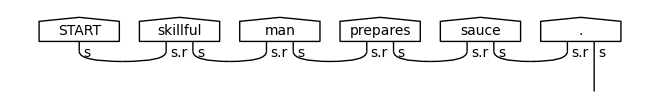

In [10]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams

train_diagrams[0].draw()

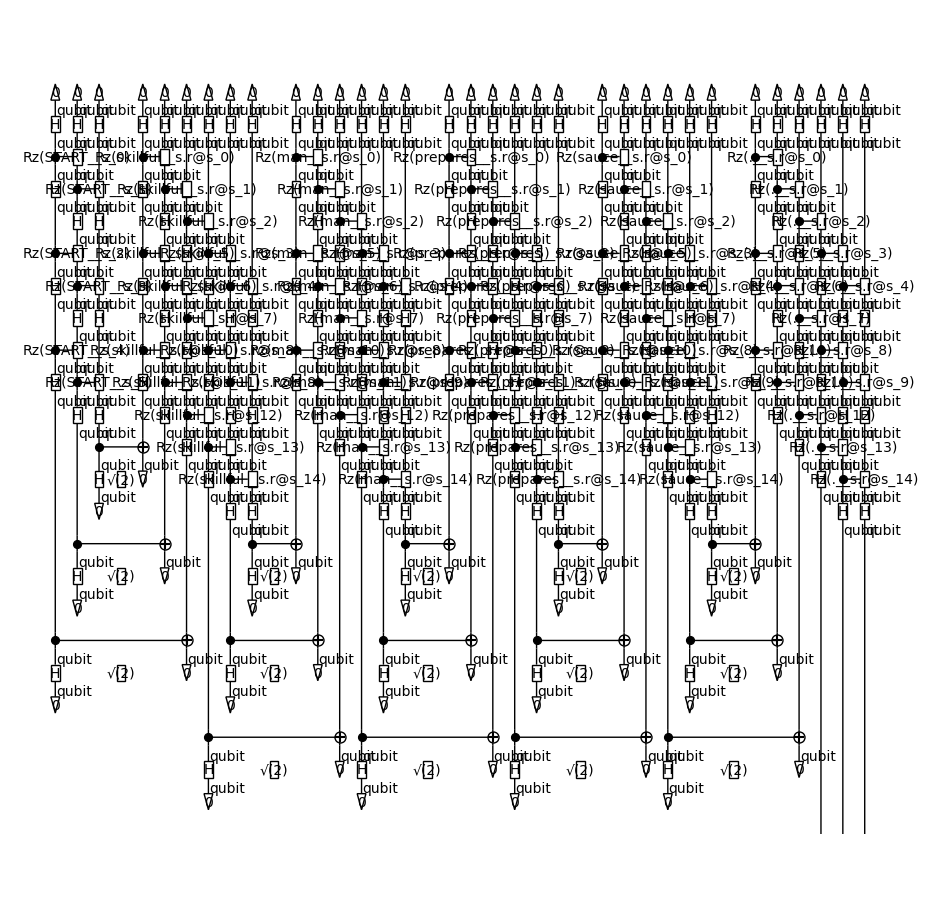

In [19]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 3, AtomicType.SENTENCE: 3},
                   n_layers=3, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 9))

In [20]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [21]:
from lambeq import CELoss, CELoss8

# Using the builtin binary cross-entropy error from lambeq
#bce = BinaryCrossEntropyLoss(use_jax=True)


In [22]:
ce = CELoss8(use_jax=True)

#acc = lambda y_hat, y: [For s in range(len(y))np.round(y_hat[ , 0,0]) == y[ ,0,0]) / len(y)  # half due to double-counting

In [23]:
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0,0]
            s1=y[s,0,0,1]
            s2=y[s,0,1,0]
            s3=y[s,0,1,1]
            s4=y[s,1,0,0]
            s5=y[s,1,0,1]
            s6=y[s,1,1,0]
            s7=y[s,1,1,1]
            ptrue.append(np.array([s0, s1, s2, s3, s4, s5, s6, s7]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0,0]
            p1=y_hat[s,0,0,1]
            p2=y_hat[s,0,1,0]
            p3=y_hat[s,0,1,1]
            p4=y_hat[s,1,0,0]
            p5=y_hat[s,1,0,1]
            p6=y_hat[s,1,1,0]
            p7=y_hat[s,1,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            q4=abs(p4)**2
            q5=abs(p5)**2
            q6=abs(p6)**2
            q7=abs(p7)**2
            qq=q0+q1+q2+q3+q4+q5+q6+q7
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            q4n=q4/qq
            q5n=q5/qq
            q6n=q6/qq
            q7n=q7/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n,q4n,q5n,q6n,q7n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2 + \
            (ppre[s,4]-qtrue[s,4])**2+(ppre[s,5]-qtrue[s,5])**2+(ppre[s,6]-qtrue[s,6])**2+(ppre[s,7]-qtrue[s,7])**2 
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [24]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [25]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [26]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

Epoch 50:    train/loss: 0.0008   valid/loss: 0.0001   train/acc: 0.8693   valid/acc: 0.9011
Epoch 100:   train/loss: 0.0003   valid/loss: 0.0000   train/acc: 0.8662   valid/acc: 0.9025
Epoch 150:   train/loss: 0.0003   valid/loss: 0.0000   train/acc: 0.8730   valid/acc: 0.9025


KeyboardInterrupt: 

Test accuracy: 0.9999967354600198


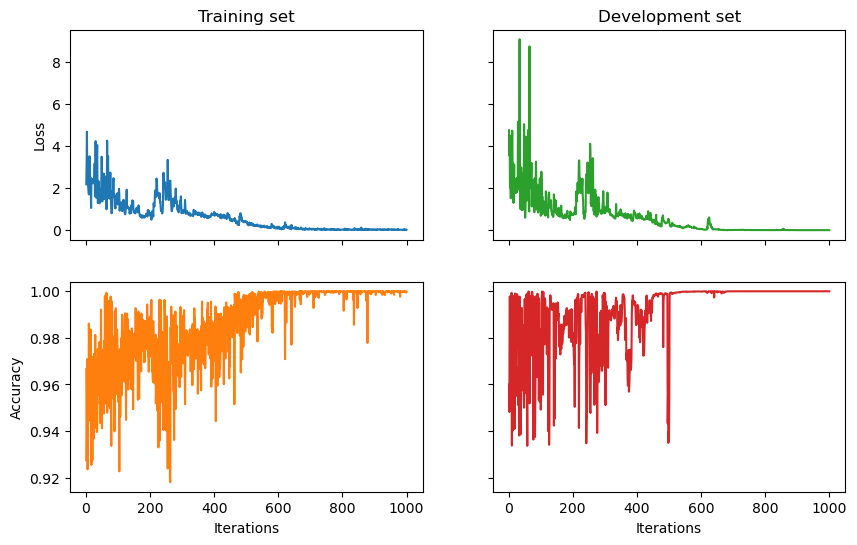

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)

In [ ]:
def OutAcc1(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0,0]
            s1=y[s,0,0,1]
            s2=y[s,0,1,0]
            s3=y[s,0,1,1]
            s4=y[s,1,0,0]
            s5=y[s,1,0,1]
            s6=y[s,1,1,0]
            s7=y[s,1,1,1]
            ptrue.append(np.array([s0, s1, s2, s3, s4, s5, s6, s7]))
            
    
        

        return ptrue

In [ ]:
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0,0]
            s1=y[s,0,0,1]
            s2=y[s,0,1,0]
            s3=y[s,0,1,1]
            s4=y[s,1,0,0]
            s5=y[s,1,0,1]
            s6=y[s,1,1,0]
            s7=y[s,1,1,1]
            ptrue.append(np.array([s0, s1, s2, s3, s4, s5, s6, s7]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0,0]
            p1=y_hat[s,0,0,1]
            p2=y_hat[s,0,1,0]
            p3=y_hat[s,0,1,1]
            p4=y_hat[s,1,0,0]
            p5=y_hat[s,1,0,1]
            p6=y_hat[s,1,1,0]
            p7=y_hat[s,1,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            q4=abs(p4)**2
            q5=abs(p5)**2
            q6=abs(p6)**2
            q7=abs(p7)**2
            qq=q0+q1+q2+q3+q4+q5+q6+q7
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            q4n=q4/qq
            q5n=q5/qq
            q6n=q6/qq
            q7n=q7/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n,q4n,q5n,q6n,q7n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2 + \
            (ppre[s,4]-qtrue[s,4])**2+(ppre[s,5]-qtrue[s,5])**2+(ppre[s,6]-qtrue[s,6])**2+(ppre[s,7]-qtrue[s,7])**2 
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [ ]:
def OutAcc2(y_hat, y):
    
    ppredic= [ ]
     
    for s in range(len(y_hat)):
            p0=y_hat[s,0,0,0]
            p1=y_hat[s,0,0,1]
            p2=y_hat[s,0,1,0]
            p3=y_hat[s,0,1,1]
            p4=y_hat[s,1,0,0]
            p5=y_hat[s,1,0,1]
            p6=y_hat[s,1,1,0]
            p7=y_hat[s,1,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            q4=abs(p4)**2
            q5=abs(p5)**2
            q6=abs(p6)**2
            q7=abs(p7)**2
            qq=q0+q1+q2+q3+q4+q5+q6+q7
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            q4n=q4/qq
            q5n=q5/qq
            q6n=q6/qq
            q7n=q7/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n,q4n,q5n,q6n,q7n]))
        
    ppre=np.array(ppredic)
        

    return ppre

In [18]:
test_out1 = OutAcc1(model(test_circuits), np.array(test_labels))

In [19]:
test_out2= OutAcc2(model(test_circuits), np.array(test_labels))

In [20]:
test_out1

[array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0]),
 array([1, 0, 0, 0])]

In [21]:
test_out2

[array([9.9209589e-01, 7.8024361e-03, 1.0093096e-04, 7.9378151e-07],
       dtype=float32),
 array([9.8862725e-01, 1.1256953e-02, 1.1446299e-04, 1.3033268e-06],
       dtype=float32),
 array([3.8101440e-05, 1.7627175e-10, 9.9995732e-01, 4.6261825e-06],
       dtype=float32),
 array([9.9301553e-01, 6.9809975e-03, 3.4641187e-06, 2.4353101e-08],
       dtype=float32),
 array([9.8328745e-01, 1.4320822e-02, 2.3573169e-03, 3.4332505e-05],
       dtype=float32),
 array([6.3052354e-03, 2.9891023e-06, 9.9322093e-01, 4.7085306e-04],
       dtype=float32),
 array([9.0179754e-05, 1.5580502e-09, 9.9989253e-01, 1.7275306e-05],
       dtype=float32),
 array([1.7626505e-02, 9.9677682e-06, 9.8180825e-01, 5.5521145e-04],
       dtype=float32),
 array([9.90268946e-01, 9.61213838e-03, 1.17778254e-04, 1.14322586e-06],
       dtype=float32),
 array([9.6895450e-01, 1.8068448e-02, 1.2739499e-02, 2.3755807e-04],
       dtype=float32),
 array([9.78192508e-01, 1.49701387e-02, 6.73422730e-03, 1.03059785e-04],
   